First, split data into training and rating set randomly, with 20% as testing set, and 80% as training set.

We can see the sparsity of the dataset movielens small is 98.3%

In [1]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In order to train models, we need to standarlize the inputs. Here I use DataLoader in torch to transform data into triplets with \<user, item, rating\>, indicating the interaction and the ground truth for optimization.

In [12]:
def mf_data_loader(training_dict, negative_sampling=False, batch_size=128
                   , user_size=256, pos_size=64):
    """
    :param training_dict: dict
    :param negative_sampling: bool
    :param user_size: int
    :param pos_size: int
    :param batch_size: int

    :return: DataLoader with (user, item, rate)
    """
    from random import choices, choice
    from torch.utils.data import DataLoader

    train_data = []
    if not negative_sampling:
        for user in training_dict:
            for item in training_dict[user]:
                train_data.append([user, item, training_dict[user][item]])

    else:
        for _ in range(user_size):
            user = choice(list(training_dict.keys()))
            pos_cands = list(training_dict[user].keys())
            item_vec = choices(pos_cands, k=pos_size)
            rate_vec = [training_dict[user][i] for i in item_vec]
            user_vec = [user] * pos_size
            train_data.extend(zip(user_vec, item_vec, rate_vec))

    return DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# 1 go over all rating pairs
dl_not_rand = mf_data_loader(training_dict=ratings_train_dict)
# 2 randomly picking users and their rated items 
dl_rand = mf_data_loader(training_dict=ratings_train_dict, negative_sampling=True)

len(list(dl_not_rand)), len(list(dl_rand))

(630, 128)

Then, we can model `Funk SVD` and `biased SVD` via torch.nn.Module.
- ref: Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.

More modularized deployments is available in <u>./recom/models/MF.py</u> 

In [11]:
import torch.nn as nn
from torch import Tensor, LongTensor


class FunkSvd(nn.Module):
    def __init__(self, n_user, n_item, k_dim):
        super(FunkSvd, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.ones_(self.embedding_user.weight) 
        nn.init.ones_(self.embedding_item.weight)
        # cannot be zeors_, otherwise gradient will disappear

    def forward(self, user, item):
        # pair-wirse
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1)
    
    def pred_all(self, ):
        return self.embedding_user.weight \
               @ self.embedding_item.weight.T 


class BiasedFunkSvd(nn.Module):
    def __init__(self, n_user, n_item, k_dim, user_deviation, item_deviation, global_bias):
        super(BiasedFunkSvd, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.ones_(self.embedding_user.weight)
        nn.init.ones_(self.embedding_item.weight)
        # global bias, and user, item deviation from that bias
        self.global_bias = nn.Parameter(Tensor([global_bias]), requires_grad=False)
        self.dev_user = nn.Parameter(Tensor(list(user_deviation.values())), requires_grad=False)
        self.dev_item = nn.Parameter(Tensor(list(item_deviation.values())), requires_grad=False)

    def forward(self, user, item):
        # dot product + bias + deviation
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1) \
               + self.dev_user[user] \
               + self.dev_item[item] \
               + self.global_bias

    def pred_all(self, ):
        user_bias = self.dev_user.view(-1,1)
        item_bias = self.dev_item.view(1,-1)

        return self.embedding_user.weight \
               @ self.embedding_item.weight.T \
               + self.global_bias \
               + user_bias \
               + item_bias


In [14]:
import time
from torch import autograd, LongTensor, device
from torch import optim
import numpy as np

def SE(input:Tensor, target:Tensor):
    # Squared Error
    return (input-target)**2


def maskedSE(input:Tensor, target:Tensor):
    # Compute squared error for testing set
    mask = (target!=0)

    return ((input[mask]-target[mask])**2)


def rating_vectorize(rat_dict, n_user, n_item):
    # transform dictionary into matrix
    from torch import zeros

    rat_mat = zeros(n_user, n_item)
    
    for u in rat_dict:
        for i in rat_dict[u]:
            rat_mat[u, i] = rat_dict[u][i]
    
    return rat_mat


def train_model(model, opt, rat_train, rat_test, use_cuda, n_epochs, report_interval):
    test_mat = rating_vectorize(rat_test, n_user, n_item)
    
    if use_cuda:
        compute_device = device('cuda')
        model.cuda()
        test_mat = test_mat.to(compute_device)
    else:
        compute_device = device('cpu')

    train_loss_by_ep = []
    test_rmse_by_ep = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = mf_data_loader(rat_train)

        ep_loss = []
        for i, batch in enumerate(train_data):
            user, item, score = batch


            model.zero_grad()

            user = autograd.Variable(LongTensor(user)).to(compute_device)
            item = autograd.Variable(LongTensor(item)).to(compute_device)
            score = autograd.Variable(score).to(compute_device)

            preds = model(user, item)
            loss = SE(input=preds, target=score)

            loss.mean().backward()
            opt.step()
            ep_loss.extend(loss.data.to(compute_device).tolist())
            
        train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))

        # test
        preds = model.pred_all()
        test_rmse = maskedSE(preds, test_mat).mean().sqrt()
        test_rmse_by_ep.append(test_rmse.data.to(compute_device).tolist())

        if report_interval > 0 \
                and ((epoch+1) % report_interval == 0):
            
            t1=time.time()
            print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)},  /Average train loss {round(sum(train_loss_by_ep[-report_interval:])/report_interval, 5)}')
            print(f'\t\t\t/Average test loss {round(sum(test_rmse_by_ep[-report_interval:])/report_interval, 5)}')
            t0=time.time()

    model = model.to('cpu') # send to cpu anyway
    
    return model, train_loss_by_ep, test_rmse_by_ep


# parameters for model

K_DIM = 16
USE_CUDA = False
N_EPOCHS = 32
REPORT_INTERVAL = 4

""" 1. FunkSVD """
fsvd = FunkSvd(n_user, n_item, K_DIM)
fsvd_opt = optim.Adam(fsvd.parameters(), lr=0.001, weight_decay=1e-8)
# train model
fsvd, fsvd_train_loss_by_ep, fsvd_test_rmse_by_ep = train_model(
    fsvd, fsvd_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)


""" 2. Biased SVD """
from recom.utils.util import compute_rat_bias
average_score, user_bias, item_bias =  compute_rat_bias(ratings_train_dict, n_user, n_item)
bsvd = BiasedFunkSvd(n_user, n_item, K_DIM
                     , user_bias, item_bias, average_score)
bsvd_opt = optim.Adam(bsvd.parameters(), lr=0.01, weight_decay=1e-5)
# train model
bsvd, bsvd_train_loss_by_ep, bsvd_test_rmse_by_ep = train_model(
    bsvd, bsvd_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)

Epoch: 4, Time: 5.75,  /Average train loss 4.82866
			/Average test loss 3.28679
Epoch: 8, Time: 5.14,  /Average train loss 1.26685
			/Average test loss 1.19259
Epoch: 12, Time: 5.32,  /Average train loss 0.92882
			/Average test loss 1.02238
Epoch: 16, Time: 4.99,  /Average train loss 0.83996
			/Average test loss 0.995
Epoch: 20, Time: 4.79,  /Average train loss 0.81725
			/Average test loss 0.99783
Epoch: 24, Time: 4.78,  /Average train loss 0.80929
			/Average test loss 1.001
Epoch: 28, Time: 4.75,  /Average train loss 0.80586
			/Average test loss 1.00467
Epoch: 32, Time: 4.77,  /Average train loss 0.80416
			/Average test loss 1.00548
Epoch: 4, Time: 6.29,  /Average train loss 1.79173
			/Average test loss 0.8167
Epoch: 8, Time: 7.75,  /Average train loss 0.80952
			/Average test loss 0.73723
Epoch: 12, Time: 7.61,  /Average train loss 0.80152
			/Average test loss 0.74013
Epoch: 16, Time: 7.59,  /Average train loss 0.80354
			/Average test loss 0.74996
Epoch: 20, Time: 7.57,  /

Only viewing the performance on testing data, Biased SVD performs better than Funk SVD for it: 1) has lower RMSE; 2) converge much faster.

However, Biased SVD sometimes fail to find users' interest among many products. To evaluate such performance, we can use f1, map, ndcg to see how well they works regarding ranking.

For now, we can have a glimpse at RMSE.

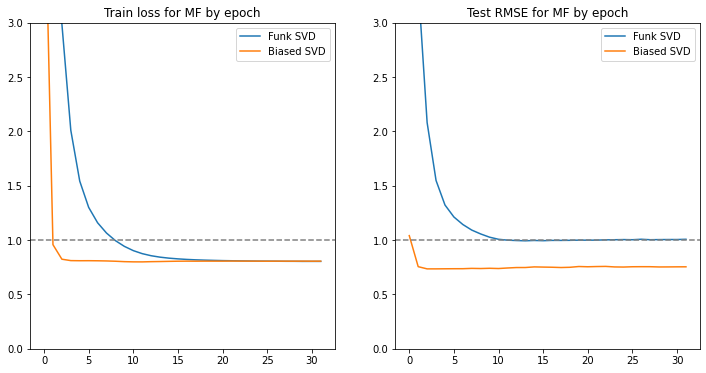

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cut your window in 1 row and 2 columns, and start a plot in the first part
plt.subplot(121)
plt.plot(list(range(N_EPOCHS)), fsvd_train_loss_by_ep)
plt.plot(list(range(N_EPOCHS)), bsvd_train_loss_by_ep)
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Funk SVD', 'Biased SVD'])
plt.title("Train loss for MF by epoch")
plt.ylim([0,3])

# And now add something in the second part:
plt.subplot(122)
plt.plot(list(range(N_EPOCHS)), fsvd_test_rmse_by_ep)
plt.plot(list(range(N_EPOCHS)), bsvd_test_rmse_by_ep) 
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Funk SVD', 'Biased SVD'])
plt.title("Test RMSE for MF by epoch")
plt.ylim([0,3])

# Show the graph
plt.show()